### advect_diffuse_3d

Use the down sample version of .nii MRI data, hope for a good interpolation. We mostly use DeepXDE to build research-grade PINN, with several optimization module, which is enough for DCE-MRI task.

#### 0. parameter adjust

In [ ]:
do_training = True
# if do not training, please provide pth path to load.
# ckpt_path = "data/adpinn_pde_v_32_20-52_l8_n128_20250930.pth"

continue_training = False
# if continue training, please provide ckpt path to load.
ckpt_path = "checkpoints/pinn-epoch=1299.ckpt"

neuron_num = 150 # 150
hid_layer_num = 5 # 5

positional_encode_nums = (20, 20, 20, 0)  # (x,y,z,t)
position_encode_freq_scale = 1.0
# DTI will cause anisotropic diffusion (2nd order term of c_net)
use_DTI = True

# RBAR will compute c_grad and c_laplacian for every point in every train phase,
# so adjust batch to be smaller to avoid CUDA-OOM; 
# also the resampling will be the bottleneck of training speed, so could set reload_dataloaders_every_n_epochs higher.
enable_rbar = True
reload_dataloaders_every_n_epochs = 100 if enable_rbar else 0

# set save/validate interval longer also to speed up training
ckpt_save_val_interval = 100

dataset_num_workers = 4

# define ordered phases explicitly
phase_order = ["init_c", "init_c_denoise", "init_v", "pde_v" ,"joint"]

train_setting = {
    "init_c":{
        "learning_rate": 2e-3,
        "max_epochs": 4_000,
        "batch_size": 122_000, # 122_000
    },
    # "init_c_denoise":{
    #     "learning_rate": 2e-3,
    #     "max_epochs": 4_000,
    #     "batch_size": 122_000, # 150_000
    # },
    "init_v":{
        "learning_rate": 2e-3,
        "max_epochs": 4_000,
        "batch_size": 122_000, # 122_000
    },
    "pde_v":{
        "learning_rate": 2e-3,
        "max_epochs": 50_000,
        "batch_size": 122_000, # 122_000
    },
    # "joint":{
    #     "learning_rate": 2e-3,
    #     "max_epochs": 1000,
    #     "batch_size": 122_000,
    # }
}


#### 1. Data preparation

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import matplotlib.pyplot as plt
import torch

torch.set_float32_matmul_precision('medium')

import torch.nn as nn
import lightning as L
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

from modules.ad_net import AD_Net
from datetime import datetime
from modules.data_module import CharacteristicDomain, DCEMRIDataModule, VelocityDataModule
from utils.visualize import interactive_quiver, fixed_quiver_image, draw_nifti_slices_with_time, draw_nifti_slices_with_threshold
from utils.io import load_dcemri_data, save_velocity_mat, load_DTI
%matplotlib widget
%load_ext autoreload
%autoreload 2


In [3]:

data,mask,pixdim,x,y,z,t = load_dcemri_data("data/dataset_downsampled.npz")

# Also need to transform anisotropic diffusivity if needed here.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

char_domain = CharacteristicDomain(data.shape, mask, t, pixdim, device)

print("L_star: ",char_domain.L_star, "T_star: ", char_domain.T_star)
# batch_size is sum over data's point
c_dataset = DCEMRIDataModule(data, char_domain,  
                           batch_size=int(mask.sum()*len(t)), num_workers=dataset_num_workers, device=device)

# set up to get num_train_points
c_dataset.setup()
print("num_train_points: ", c_dataset.num_train_points, "batch_size: ", c_dataset.batch_size)

data_shape:  (38, 48, 38, 18) pixdim:  [0.41666666 0.41666666 0.41666666]
domain_shape:  (38,) (48,) (38,) (18,)
min_c:  0.0 max_c:  705.13226
L_star:  [7.70833315 9.79166643 7.70833315] T_star:  34.0
num_train_points:  47610 batch_size:  95220


In [4]:
if use_DTI:
    DTI_tensor,DTI_MD = load_DTI(char_domain, "data/DCE_nii_data/dti_tensor_3_3.mat", data.shape[:3])
else:
    DTI_tensor = None

char_domain.set_DTI_or_coef(DTI_tensor if use_DTI else 2.4e-4)
print("Pe_g: ", char_domain.Pe_g)

Original DTI shape:  (128, 160, 128, 3, 3)
Resized DTI shape:  (38, 48, 38, 3, 3)
DTI_MD min:  0.0015608029642299327 DTI_MD max:  0.07868427531483783 DTI_MD mean:  0.02050254089454866
Pe_g:  2.0766667945861026


In [5]:
if use_DTI:
    draw_nifti_slices_with_threshold(DTI_MD, brain_mask=mask)

output_tag = (f"{data.shape[0]}_{int(t[0])}-{int(t[-1])}"
            f"_pos{position_encode_freq_scale}{positional_encode_nums[0]}"
            f"_l{hid_layer_num}_n{neuron_num}{'' if DTI_tensor is None else '_DTI'}"
            f"_{datetime.now().strftime('%m%d')}")

Volume shape: (38, 48, 38) dtype: float64


interactive(children=(IntSlider(value=19, description='z', max=37), FloatSlider(value=0.5, description='thr', …

In [6]:
# use front-tracking to get initial velocity field.
from utils.front_tracking import front_tracking_velocity
# shape (nx, ny, nz, 3), only use half of the timestep to training, consistant with c_dataset

initial_velocity_field = front_tracking_velocity(data[:,:,:,::2], 
                                                 dt=t[2] - t[0])
# scaling using V_star
initial_velocity_field /= char_domain.V_star
# draw initial velocity magnitude
vel_mag = np.linalg.norm(initial_velocity_field, axis=-1)

# print(pixdim, char_domain.domain_shape, char_domain.L_star, char_domain.T_star, char_domain.V_star)
print("velocity max and min: ", vel_mag.max(), vel_mag.min())

draw_nifti_slices_with_threshold(vel_mag)

v_dataset = VelocityDataModule(initial_velocity_field, char_domain,
                              batch_size=int(mask.sum()), num_workers=dataset_num_workers, device=device)

velocity max and min:  1.4794895833165964 0.0
Volume shape: (38, 48, 38) dtype: float64


interactive(children=(IntSlider(value=19, description='z', max=37), FloatSlider(value=0.5, description='thr', …

#### 2. Network definition

Here only define a base advect-diffuse PINN that learn the whole, it is reported in [J. D. Toscano et al. 2025](https://doi.org/10.1101/2025.07.30.667741) , that pure AD instead of Darcy's law cannot capture bimodal velocity distribution. 

This version has two variants:
1. simply using FNN to produce velocity field, without any pruning on solution space.
2. physics constrained divergence-free to the velocity net, so raw v_net predict the vector potential $\Phi(x,y,z)$ instead 

Also define training sequence, different variant network has different training loss.


In [7]:
# Training variant 1: init C_Net
from modules.c_trainer import CNet_Init, CNet_DenoiseInit
# Training varient 2: init V_Net (need heuristic estimate)
# 3. only optimize v + D, using advect-diffuse.
# 4. joint optimize c + v + D, using advect-diffuse
from modules.ad_trainer import ADPINN_InitV, ADPINN_PDE_V, ADPINN_Joint


#### 3. Training step

- first we has initializaiton for c and v net
- then pde loss for only v net
- finally joint optimization.

In [ ]:
# Instantiate the model and trainer or load from checkpoint:
ad_net = AD_Net(c_layers=[4] + [neuron_num for _ in range(hid_layer_num)] + [1],
    u_layers=[3] + [neuron_num for _ in range(hid_layer_num)] + [3],
    data=data,C_star=c_dataset.C_star,
    incompressible=False,
    char_domain=char_domain,
    freq_nums=positional_encode_nums,
    gamma_space=position_encode_freq_scale)

if do_training:
    logger = TensorBoardLogger("tb_logs", name="seqtrain_ADPINN")
    # save every 100 epochs
    # save every 100 epochs
    checkpoint_callback_best = ModelCheckpoint(
        # dirpath="checkpoints/", # still save to logs.
        filename="pinn-{epoch:04d}",
        monitor='val_data_loss',
        save_top_k=1,                # keep latest checkpoints
        every_n_epochs=ckpt_save_val_interval            # save every 100 epochs
    )
    checkpoint_callback_latest = ModelCheckpoint(
        filename="pinn-{epoch:04d}",
        save_top_k=0,             # no best checkpoints
        save_last=True,
        every_n_epochs=ckpt_save_val_interval
    )
    # because large batch pointset, steps in one epoch is small.
    trainer = Trainer(reload_dataloaders_every_n_epochs= reload_dataloaders_every_n_epochs, log_every_n_steps=5, 
                      check_val_every_n_epoch = ckpt_save_val_interval, callbacks=[checkpoint_callback_best, checkpoint_callback_latest] , logger=logger)
    last_model = None

    train_phase_togo = [phase for phase in phase_order if phase in train_setting]

    if continue_training:
        # first check whether the ckpt_path is a lightning checkpoint or state_dict
        checkpoint = torch.load(ckpt_path, map_location="cpu")
        # also check whether sequential training step meet our next training phase
        if "state_dict" in checkpoint and "train_phase" in checkpoint and checkpoint["train_phase"] == train_phase_togo[0]:
            # could directly fit the trainer.
            last_epoch = checkpoint["epoch"]
            total_epochs = last_epoch
            print(f"Continue training from phase {checkpoint['train_phase']} with epoch {last_epoch}")
        else:
            ad_net.load_state_dict(checkpoint['state_dict'], strict=False)
            total_epochs = 0
            continue_training = False # already loaded state_dict, no need to continue training
    else:
        total_epochs = 0
    
    for phase in train_phase_togo:
        cfg = train_setting[phase]
        lr = cfg.get("learning_rate", 1e-3)
        max_epochs = cfg.get("max_epochs", 1000)
        batch_size = cfg.get("batch_size", 222_000)
        if phase == "init_c":
            pinn_model = CNet_Init(ad_net.c_net, c_dataset.num_train_points, 
                                   learning_rate=lr)
            datamodule = c_dataset
        elif phase == "init_c_denoise":
            pinn_model = CNet_DenoiseInit(ad_net.c_net, c_dataset.num_train_points, 
                                          learning_rate=lr)
            datamodule = c_dataset
        elif phase == "init_v":
            pinn_model = ADPINN_InitV(ad_net, c_dataset.num_train_points, learning_rate=lr)
            datamodule = v_dataset # just coarse initialie, do not need rbar.
        elif phase == "pde_v":
            pinn_model = ADPINN_PDE_V(ad_net, c_dataset.num_train_points, learning_rate=lr)
            datamodule = c_dataset
        elif phase == "joint":
            pinn_model = ADPINN_Joint(ad_net, c_dataset.num_train_points, learning_rate=lr)
            datamodule = c_dataset
        else:
            continue

        pinn_model.set_enable_rbar(enable_rbar)
        if enable_rbar:
            datamodule.set_RBA_resample_model(pinn_model)

        datamodule.batch_size = batch_size
        
        # update epochs per phase on the same Trainer
        total_epochs += max_epochs
        trainer.fit_loop.max_epochs = total_epochs

        # optional: tag phase in TensorBoard
        trainer.logger.experiment.add_text("phase/start", phase, global_step=trainer.global_step)
        # pinn_model.log = lambda name, value, **kw: super(type(pinn_model), pinn_model).log(f"{phase}/{name}", value, **kw)
        trainer.fit(pinn_model, datamodule=datamodule,
                    ckpt_path=ckpt_path if continue_training and last_model is None else None)
        ckpt_name = (f"data/adpinn_{phase}_{output_tag}.pth")
        trainer.save_checkpoint(ckpt_name)
        
        last_model = pinn_model
    
    pinn_model = last_model
else:
    if continue_training:
        checkpoint = torch.load(ckpt_path)
        ad_net.load_state_dict(checkpoint, strict=False)
    pinn_model = ADPINN_Joint(ad_net)


# After training, visualize the learned velocity field and diffusivity
# Extract learned parameters
D_learned = pinn_model.ad_net.D.item()

print(f"Learned diffusivity D: {D_learned}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at checkpoints/pinn-epoch=1299.ckpt
w:\bigTool\Anaconda\envs\AI\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:445: The dirpath has changed from 'C:\\Users\\Winfred X\\Desktop\\deepsearch\\MRI_PINN\\advect_diffuse\\checkpoints' to 'tb_logs\\seqtrain_ADPINN\\version_43\\checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Continue training from phase init_c with epoch 1299



  | Name  | Type  | Params | Mode 
----------------------------------------
0 | c_net | C_Net | 109 K  | train
----------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.438     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at checkpoints/pinn-epoch=1299.ckpt


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


AttributeError: 'tuple' object has no attribute 'tb_frame'

#### 4. Visualize result.
Finally we will save the velocity mat to run GLAD (get pathline figure) in matlab.

(600, 700, 3)


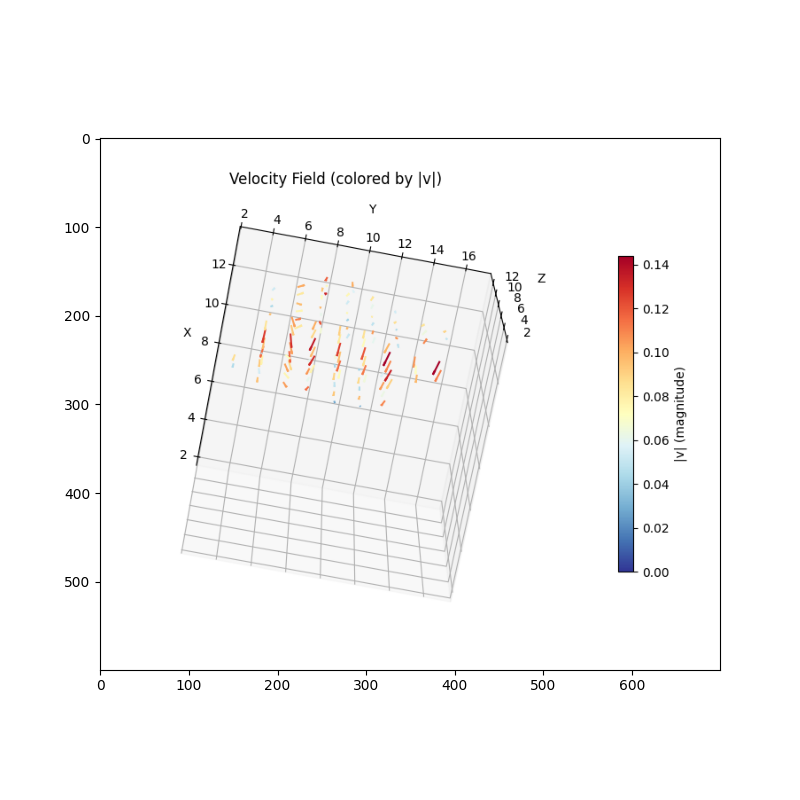

In [ ]:

# 1. Extract learned velocity field on a grid for visualization
pinn_model.to(device)
# using mask to filter out the background vectors
# _ = interactive_quiver(vx, vy, vz, pixdim, default_elev=-62.76, default_azim=-10.87)
nx, ny, nz = data.shape[0], data.shape[1], data.shape[2]
v_fig, vx,vy,vz = pinn_model.v_net.draw_velocity_volume()
print(v_fig.shape)
plt.figure(figsize=(8,8))
plt.imshow(v_fig)
# use a grid (from real to characteristic) to extract velocity field

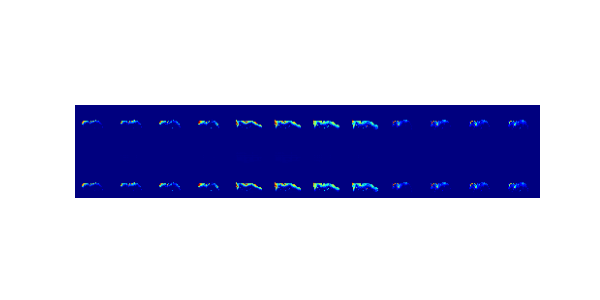

In [ ]:
# use pinn_model.val_slice_4d to draw concentration slices
c_vis_list = pinn_model.c_net.draw_concentration_slices()
plt.figure(figsize=(6,3))
plt.imshow(c_vis_list, cmap='jet', vmin=0, vmax=1)
plt.axis('off')
plt.show()

torch.Size([737280, 4])
Pred shape: (32, 40, 32, 18) True shape: (32, 40, 32, 18)


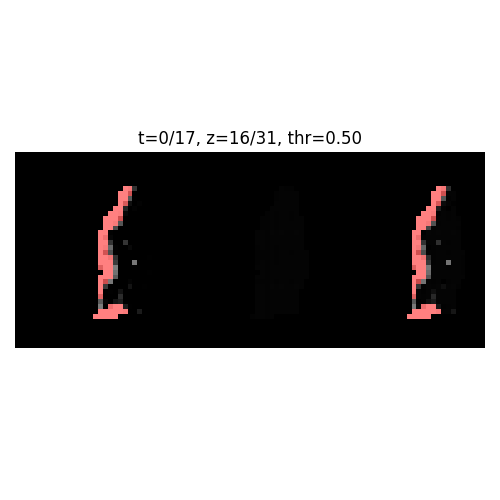

In [ ]:
# 2. Extract all density field with x,y,z,t 4D grid for visualization

grid_tensor_4d = char_domain.get_characteristic_geotimedomain()  # include time part
print(grid_tensor_4d.shape)
def predict_concentration_4d(model, pts4, nx, ny, nz, nt, batch_size=200_000):
    out_list = []
    with torch.no_grad():
        for i in range(0, pts4.shape[0], batch_size):
            chunk = pts4[i:i+batch_size]
            pred = model.c_net(chunk)
            out_list.append(pred.cpu())
    C_flat = torch.cat(out_list, dim=0).numpy().reshape(nx, ny, nz, nt)
    # C_flat = torch.cat(out_list, dim=0).numpy().reshape(nx, ny, nz, nt)
    return C_flat

C_pred_4d = predict_concentration_4d(pinn_model, grid_tensor_4d, nx, ny, nz, len(t), batch_size=200_000)

# Back to physical units
C_pred_4d *= c_dataset.C_star
print("Pred shape:", C_pred_4d.shape, "True shape:", data.shape)  # (nx, ny, nz, nt)

_ = draw_nifti_slices_with_time(C_pred_4d, data, mask)
# try calculate loss with true data
# from sklearn.metrics import mean_squared_error
# mse_overall = mean_squared_error(data.flatten(), C_pred_4d.flatten())


In [ ]:
# Export velocity to .mat format so that we could run GLAD using matlab
# the rOMT code require velocity reshaped to N*3 x 1, with unit cell/min
save_velocity_mat(vx,vy,vz,pixdim,path=f"data/ad_net_velocity_{output_tag}.mat")

(491520, 1)
